In [ ]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")

GPU is not available


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn
import glob
import pickle
import os
import cv2
import numpy as np
import skimage
from skimage import data, color, exposure
import matplotlib.pyplot as plt
from collections import deque
from scipy.ndimage import label
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution2D, Flatten, Input, Conv2D, MaxPooling2D, Lambda
from keras import optimizers
from keras.layers import BatchNormalization
from keras.models import Model
from sklearn.model_selection import train_test_split
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.transform import resize

# Show plots inline notebook
%matplotlib inline

In [ ]:
# Paths to car and non-car images
cars = glob.glob("/content/drive/MyDrive/datasets/vehicles/*/*.png")
non_cars = glob.glob("/content/drive/MyDrive/datasets/non-vehicles/*/*.png")

# Desired dimensions for resizing
resize_shape = (260, 1280)

# Read and resize images, then store them in X
X = []
for file in cars:
    img = skimage.io.imread(file)
    img_resized = skimage.transform.resize(img, resize_shape, anti_aliasing=True)
    X.append(img_resized)
for file in non_cars:
    img = skimage.io.imread(file)
    img_resized = skimage.transform.resize(img, resize_shape, anti_aliasing=True)
    X.append(img_resized)
X = np.array(X)

# Generate Y Vector
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))])

# Split train and validation dataset with 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=63)

# Show messages
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

KeyboardInterrupt: 

In [ ]:
Y_train = Y_train.reshape((Y_train.shape[0],1)).astype(int)
Y_test = Y_test.reshape((Y_test.shape[0],1)).astype(int)
print(Y_train.shape)
print(Y_test.shape)

(7912, 1)
(880, 1)


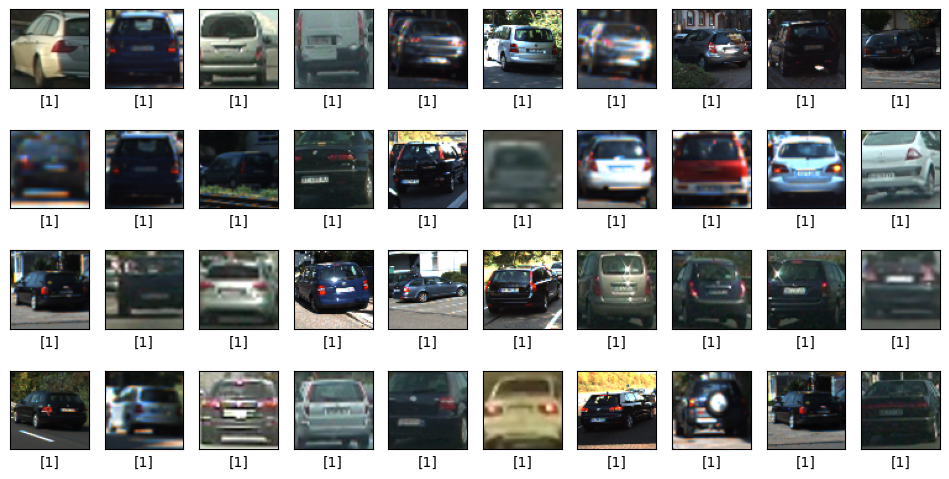

In [ ]:
def showRandomImages():
    fig = plt.figure(figsize=(12, 6))
    for i in range(0, 40):
        number = np.random.randint(0, len(X_train))
        axis = fig.add_subplot(4,10,i+1)
        axis.set_xlabel(Y_train[number])
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        axis.imshow(X_train[number])
    plt.show()

showRandomImages()

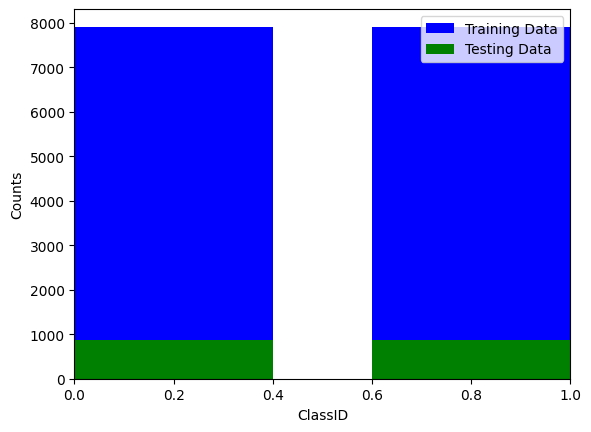

In [ ]:
def showDistribution():
    _, training_counts = np.unique(Y_train, return_counts = True)
    _, test_counts = np.unique(Y_test, return_counts = True)
    plt.bar( np.arange( 2 ), training_counts,   color='b', label='Training Data')
    plt.bar( np.arange( 2 ), test_counts,  color='g', label='Testing Data')
    plt.xlabel('ClassID')
    plt.ylabel('Counts')
    plt.xlim([0, 1])
    plt.legend()
    plt.show()

showDistribution()

In [ ]:
def create_model(input_shape=(64,64,3)):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Center and normalize our data
    model.add(Lambda(lambda x: x/127.5 - 1.))
    # 1st conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Conv2D(128, 3, 3, activation='relu', name='conv1', padding="same"))
    model.add(Dropout(0.3))
    # 2nd conv layer with 128 filter, 3x3 each, 50% dropout
    model.add(Conv2D(128, 3, 3, activation='relu', name='conv2',padding="same"))
    model.add(Dropout(0.3))
    # 3rd conv layer with 128 filter, 3x3 each, 8x8 pooling and dropout
    model.add(Conv2D(128, 3, 3, activation='relu', name='conv3',padding="same"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
    # Fully connected layer
    model.add(Conv2D(128, (1, 1), activation="relu", padding="same"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Conv2D(1, (1, 1), activation="sigmoid", padding="same"))


    return model

model = create_model()
model.summary()
model.add(Flatten())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 22, 22, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 1, 1, 128)           │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 1, 1)             │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,905 (1.21 MB)

 Trainable params: 315,649 (1.20 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
62/62 - 29s - 466ms/step - accuracy: 0.7103 - loss: 0.2031 - val_accuracy: 1.0000 - val_loss: 0.0790
Epoch 2/20
62/62 - 28s - 458ms/step - accuracy: 0.9709 - loss: 0.0632 - val_accuracy: 1.0000 - val_loss: 0.0177
Epoch 3/20
62/62 - 38s - 607ms/step - accuracy: 0.9996 - loss: 0.0118 - val_accuracy: 1.0000 - val_loss: 0.0060
Epoch 4/20
62/62 - 40s - 641ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 5/20
62/62 - 41s - 655ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 6/20
62/62 - 26s - 414ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 7/20
62/62 - 41s - 663ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 9.4895e-04
Epoch 8/20
62/62 - 24s - 383ms/step - accuracy: 1.0000 - loss: 8.7305e-04 - val_accuracy: 1.0000 - val_loss: 7.1641e-04
Epoch 9/20
62/62 - 42s - 671ms/step - accuracy: 1.0000 - loss: 6.8196e-04 - val_accuracy: 1.

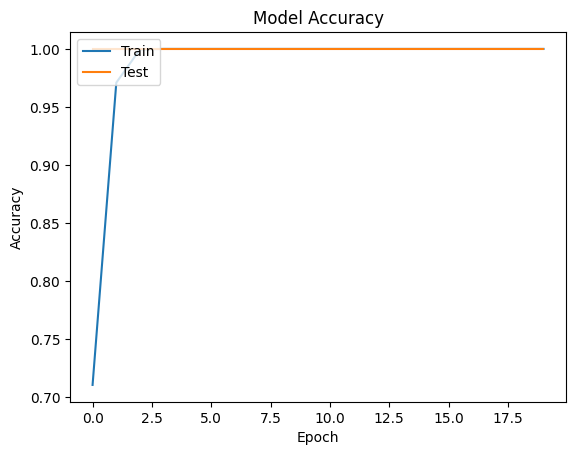

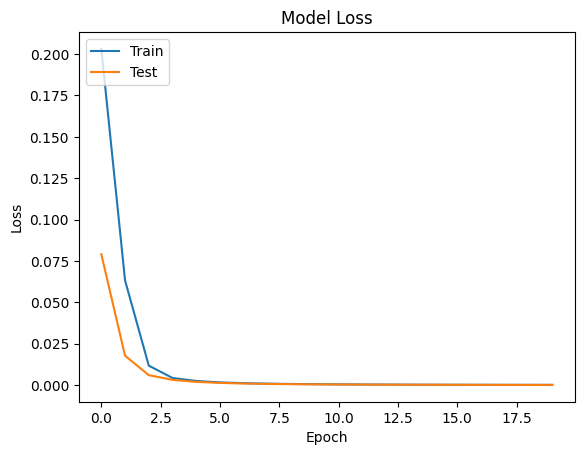

In [ ]:

def plot_results(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
from tensorflow.keras.optimizers import Adam
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['accuracy'])
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, verbose=2, validation_data=(X_test, Y_test))

# Plot the results
plot_results(history)

# Save model weights
model.save_weights('/content/drive/MyDrive/datasets/model.weights.h5')


In [ ]:
# Load the fine-tuned for the final network
model.load_weights('/content/drive/MyDrive/datasets/model.weights.h5')
print("Weights loaded!")

Weights loaded!


NN Prediction: CAR with value 0.9896753
Ground-truth: CAR with value [1]


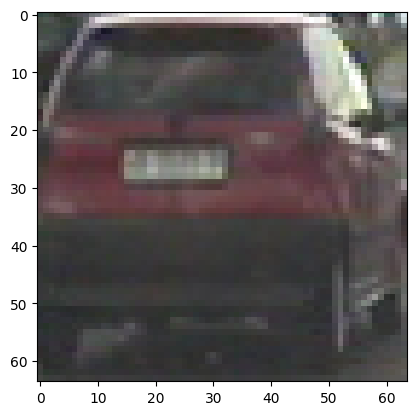

In [ ]:
# Pick a random image from the test set
rand = np.random.randint(X_test.shape[0])
plt.imshow(X_test[rand])

# Predict the correct label
sample = np.reshape(X_test[rand], (1, 64,64,3))
prediction = model.predict(sample, batch_size=64, verbose=0)
prediction = prediction[0][0]

# Check if the prediction is a car or a non-car
if prediction >= 0.5:
    print("NN Prediction: CAR with value " + str(prediction))
else:
    print("NN Prediction: NO CAR with value " + str(prediction))

# Compare with the ground-truth
truth = Y_test[rand]
if truth == 1:
    print("Ground-truth: CAR with value " + str(truth))
else:
    print("Ground-truth: NO CAR with value " + str(truth))

(720, 1280, 3)


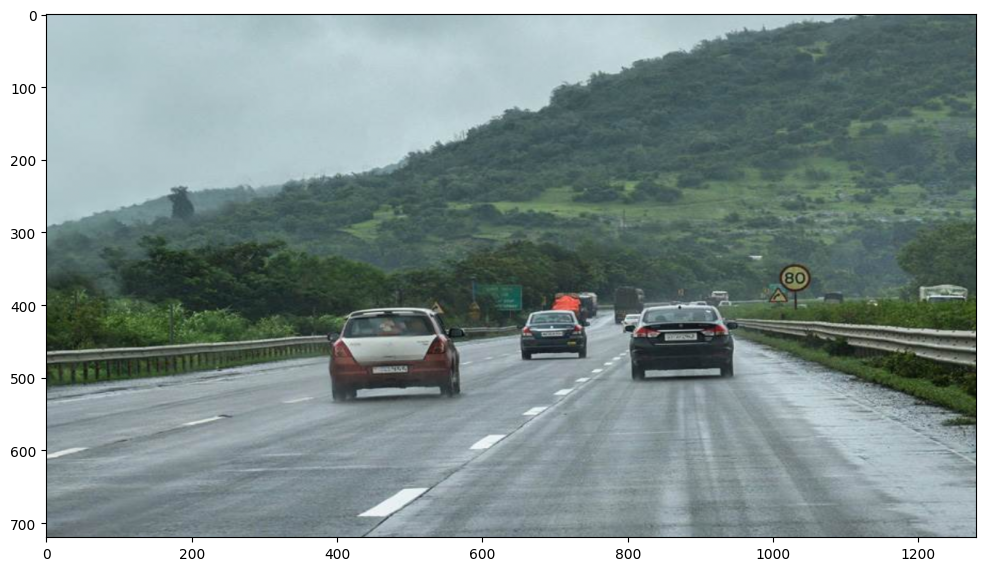

In [ ]:
# Load a specific sample image
img = skimage.io.imread('/content/drive/MyDrive/datasets/road.jpg')
img = skimage.transform.resize(img, (720, 1280), anti_aliasing=True)
# Display it
fig = plt.figure(figsize=(12,20))
plt.imshow(img)
print(img.shape)

In [ ]:
def create_model_heatmap(input_shape=(260, 1280, 3)):
    model1 = Sequential()

    # Input layer
    model1.add(Input(shape=input_shape))

    # Center and normalize data
    model1.add(Lambda(lambda x: x / 127.5 - 1.0))

    # 1st convolutional layer
    model1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model1.add(Dropout(0.3))  # Reduced dropout

    # 2nd convolutional layer
    model1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model1.add(Dropout(0.3))

    # 3rd convolutional layer with pooling
    model1.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
    model1.add(MaxPooling2D(pool_size=(2, 2)))
    model1.add(Dropout(0.3))

    # 4th convolutional layer (fully connected through 1x1)
    model1.add(Conv2D(128, (1, 1), activation="relu", padding="same"))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.3))

    # Output layer: single-channel heatmap output
    model1.add(Conv2D(1, (1, 1), activation="sigmoid", padding="same"))  # Use sigmoid for heatmap output

    return model1

model_heat = create_model_heatmap()
model_heat.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_27 (Lambda)                   │ (None, 260, 1280, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_54 (Conv2D)                   │ (None, 260, 1280, 128)      │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 260, 1280, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_55 (Conv2D)                   │ (None, 260, 1280, 128)      │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_109 (Dropout)                │ (None, 260, 1280, 128)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 260, 1280, 128)      │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 130, 640, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 130, 640, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 130, 640, 128)       │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 130, 640, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 130, 640, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 130, 640, 1)         │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 315,905 (1.21 MB)

 Trainable params: 315,649 (1.20 MB)

 Non-trainable params: 256 (1.00 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


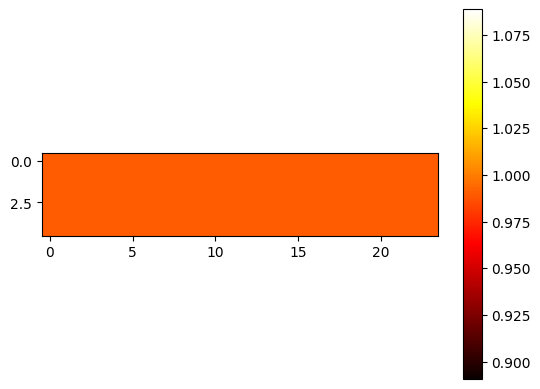

(1, 5, 24, 1)


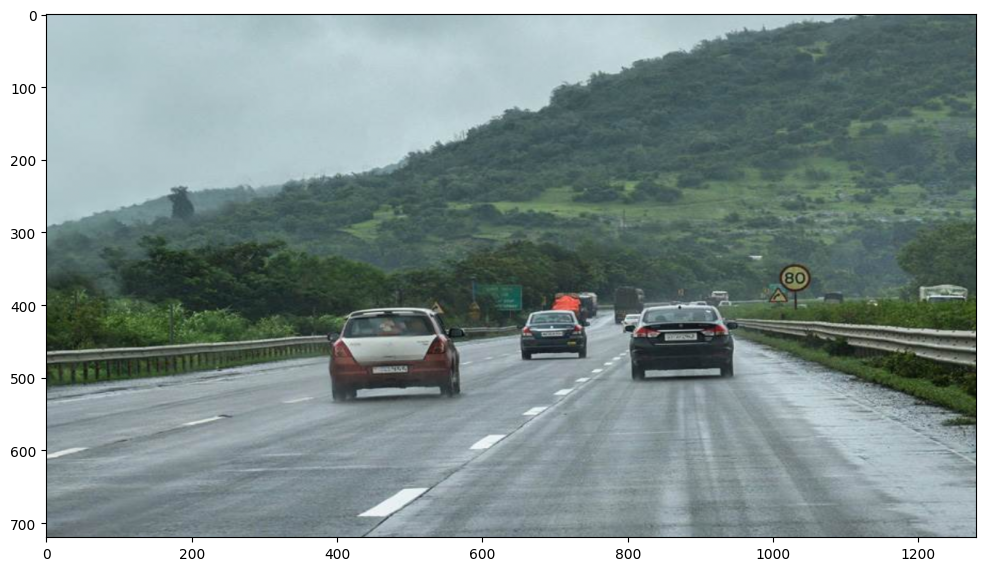

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img


def search_cars(img):
     # Crop the image to 440-660px in the vertical direction
    cropped = img[400:660, 0:1280]
    cropped = np.expand_dims(cropped, axis=0)  # Add batch dimension
    cropped = cropped / 255.0  # Normalize if needed

    # Predict using the model
    heat = heatmodel.predict(cropped)
    plt.imshow(heat[0, :, :, 0], cmap='hot')
    plt.colorbar()
    plt.show()
    print(heat.shape)
    # Find rectangles that are interesting
    xx, yy = np.meshgrid(np.arange(heat.shape[2]), np.arange(heat.shape[1]))
    x = (xx[heat[0, :, :, 0] > 0.99])
    y = (yy[heat[0, :, :, 0] > 0.99])
    window_size = 64
    hot_windows = []
    for i, j in zip(x, y):
        y1 = max(400 + j * window_size, 400)
        y2 = min(400 + j * window_size + window_size, 660)

        hot_windows.append(((i * window_size, y1),
                            (i * window_size + window_size, y2)))

    return hot_windows


# Init a version of our network with another resolution without the flatten layer
heatmodel = create_model((260, 1280, 3))
# Load the weights
heatmodel.load_weights('/content/drive/MyDrive/datasets/model.weights.h5')

# Search for our windows
hot_windows = search_cars(img)

# Draw the found boxes on the test image
window_img = draw_boxes(img, hot_windows, (0, 255, 0), 6)
# Show the image with the windows on top
fig = plt.figure(figsize=(12,20))
plt.imshow(window_img)

Number of hot_windows detected: 120
Bbox coordinates: ((0, 400), (64, 464))
Bbox coordinates: ((64, 400), (128, 464))
Bbox coordinates: ((128, 400), (192, 464))
Bbox coordinates: ((192, 400), (256, 464))
Bbox coordinates: ((256, 400), (320, 464))
Bbox coordinates: ((320, 400), (384, 464))
Bbox coordinates: ((384, 400), (448, 464))
Bbox coordinates: ((448, 400), (512, 464))
Bbox coordinates: ((512, 400), (576, 464))
Bbox coordinates: ((576, 400), (640, 464))
Bbox coordinates: ((640, 400), (704, 464))
Bbox coordinates: ((704, 400), (768, 464))
Bbox coordinates: ((768, 400), (832, 464))
Bbox coordinates: ((832, 400), (896, 464))
Bbox coordinates: ((896, 400), (960, 464))
Bbox coordinates: ((960, 400), (1024, 464))
Bbox coordinates: ((1024, 400), (1088, 464))
Bbox coordinates: ((1088, 400), (1152, 464))
Bbox coordinates: ((1152, 400), (1216, 464))
Bbox coordinates: ((1216, 400), (1280, 464))
Bbox coordinates: ((1280, 400), (1344, 464))
Bbox coordinates: ((1344, 400), (1408, 464))
Bbox coor

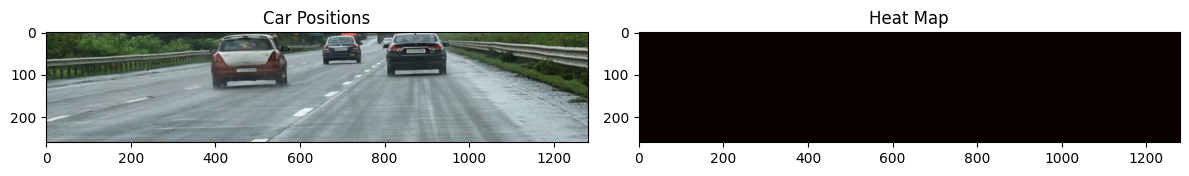

Number of cars found: 0


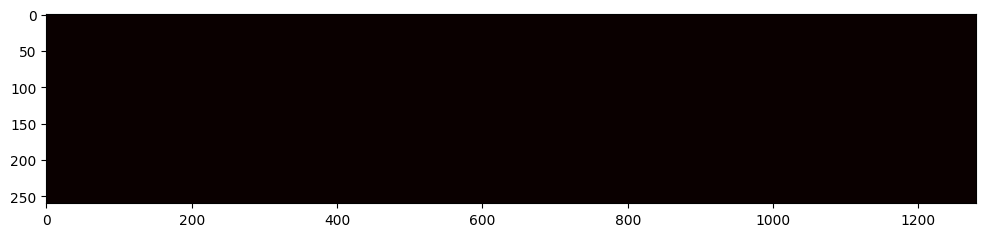

In [ ]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 0), 6)
    # Return the image
    return img

# Debugging step: Check if hot_windows is populated
print(f"Number of hot_windows detected: {len(hot_windows)}")
for bbox in hot_windows:
    print(f"Bbox coordinates: {bbox}")

# Create image for the heatmap similar to one shown above
heat = np.zeros_like(img[:, :, 0]).astype(np.float64)

# Add heat to each box in the box list
heat = add_heat(heat, hot_windows)

# Debugging step: Check heatmap values before thresholding
print(f"Heatmap max value before threshold: {np.max(heat)}")
print(f"Heatmap min value before threshold: {np.min(heat)}")

# Apply threshold to help remove false positives
heat = apply_threshold(heat, 1)  # Lower threshold for testing

# Visualize the heatmap when displaying
heatmap = np.clip(heat, 0, 255)

# Debugging step: Check heatmap values after thresholding
print(f"Heatmap max value after threshold: {np.max(heatmap)}")
print(f"Heatmap min value after threshold: {np.min(heatmap)}")

# Find final boxes from heatmap using label function
boxes = label(heatmap)

# Create the final image
draw_img = draw_labeled_bboxes(np.copy(img), boxes)

# Show the car positions and the heatmap with the threshold applied
fig = plt.figure(figsize=(12, 20))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')

plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')

fig.tight_layout()
plt.show()

# Debugging step: Print number of cars found
print(f"Number of cars found: {boxes[1]}")

# Display labeled boxes as a heatmap
fig = plt.figure(figsize=(12, 20))
plt.imshow(boxes[0], cmap='hot')
plt.show()


In [ ]:
# Define the source points
src_points = np.float32([[0 , 720],
                         [1280 , 720],
                         [750 , 470],
                         [530 , 470]])

# Define the destination points
dst_points = np.float32([[320 , 720],
                         [960 , 720],
                         [960 , 0],
                         [320 , 0]])
# Storing our averages
prev_frames = []
prev_curvatures = []
prev_car_off = []

def region_of_interest(img,vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def applyTransformation(img):
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src_points, dst_points)

    # Warp the image using OpenCV warpPerspective()
    transformed = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

    # Return transformed image
    return transformed

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def mag_thresh(img, thresh_min=0, thresh_max=255):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=9)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1

    # Return the binary image
    return binary_output

def applySobelMask(img):
    # Convert to HLS and extract L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Apply sobel in x direction on L and S channel
    l_channel_sobel_x = abs_sobel_thresh(l_channel,'x', 20, 200)
    s_channel_sobel_x = abs_sobel_thresh(s_channel,'x', 60, 200)
    sobel_combined_x = cv2.bitwise_or(s_channel_sobel_x, l_channel_sobel_x)

    # Apply magnitude sobel
    l_channel_mag = mag_thresh(l_channel, 80, 200)
    s_channel_mag = mag_thresh(s_channel, 80, 200)
    mag_combined = cv2.bitwise_or(l_channel_mag, s_channel_mag)

    # Combine all the sobel filters
    mask_combined = cv2.bitwise_or(mag_combined, sobel_combined_x)

    # Mask out the desired image and filter image again
    mask_combined = region_of_interest(mask_combined, np.array([[(330, 0),(950, 0), (950, 680), (330, 680)]]))

    # Return the sobel mask
    return mask_combined

def applyColorMask(img):
    # Convert to HLS and extract S and V channel
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define color thresholds in HSV
    white_low = np.array([[[0, 0, 210]]])
    white_high = np.array([[[255, 30, 255]]])

    yellow_low = np.array([[[18, 80, 80]]])
    yellow_high = np.array([[[30, 255, 255]]])

    # Apply the thresholds to get only white and yellow
    white_mask = cv2.inRange(img_hsv, white_low, white_high)
    yellow_mask = cv2.inRange(img_hsv, yellow_low, yellow_high)

    # Bitwise or the yellow and white mask
    color_mask = cv2.bitwise_or(yellow_mask, white_mask)
    return color_mask

def combineMasks(sobel_mask, color_mask):
    mask_combined = np.zeros_like(sobel_mask)
    mask_combined[(color_mask>=.5)|(sobel_mask>=.5)] = 1
    return mask_combined

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def slidingWindow(img):
    # Window settings
    window_width = 50
    window_height = 100
    # How much to slide left and right for searching
    margin = 30

    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width)

    # Find the starting point for the lines
    l_sum = np.sum(img[int(3*img.shape[0]/5):,:int(img.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(img[int(3*img.shape[0]/5):,int(img.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(img.shape[1]/2)

    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1, (int)(img.shape[0] / window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(img[int(img.shape[0]-(level+1)*window_height):int(img.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        # Find the best left centroid by using past left center as a reference
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,img.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,img.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    # If we have found any window centers, print error and return
    if len(window_centroids) == 0:
        print("No windows found in this frame!")
        return

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(img)
    r_points = np.zeros_like(img)

    # Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,img,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,img,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle
    template = np.array(cv2.merge((template, template, template)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((img, img, img)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # Extract left and right line pixel positions
    leftx = np.nonzero(l_points)[1]
    lefty = np.nonzero(l_points)[0]
    rightx = np.nonzero(r_points)[1]
    righty = np.nonzero(r_points)[0]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Return left and right lines as well as the image
    return left_fit, right_fit, output

def calcCurvature(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    ploty = np.linspace(0, 719, num=720)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Set y-value to bottom of the image
    y_eval = 719
    # Calculate left and right curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Match them together
    curverad = (left_curverad + right_curverad) / 2

    # Use the last ten values and build the average of them
    prev_curvatures.append(curverad)
    avg_curverad = np.average(prev_curvatures[-10:])

    # Return the average curvature in meter
    return avg_curverad

def calcCarOff(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Left and right line intercept on x axis
    left_intcpt = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    right_intcpt = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]

    # Calculate the middle of the lanes
    lane_mid = (left_intcpt + right_intcpt)/2.0

    # Calculate the offset
    car_off = (lane_mid - 1280/2.0)*xm_per_pix

    # Average over the last ten positions
    prev_car_off.append(car_off)
    avg_car_off = np.average(prev_car_off[-10:])

    return avg_car_off

def displayInfo(img, curverad, car_off):
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    curve_disp_txt = 'Curvature: ' + str(np.round(curverad,2)) + 'm'
    off_disp_txt = 'Car offset: ' + str(np.round(car_off,2)) + 'm'
    cv2.putText(img, curve_disp_txt, (20, 30), font, 1, (0,0,0), 2)
    cv2.putText(img, off_disp_txt, (20, 60), font, 1, (0,0,0), 2)
    return img

def applyBackTrans(img, left_fit, right_fit):
    ploty = np.linspace(0, 719, num=720)
    # Calculate left and right x positions
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Defining a blank mask to start with
    polygon = np.zeros_like(img)

    # Create an array of points for the polygon
    plot_y = np.linspace(0, img.shape[0]-1, img.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, plot_y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, plot_y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the polygon in blue
    cv2.fillPoly(polygon, np.int_([pts]), (0, 0, 255))

    # Calculate top and bottom distance between the lanes
    top_dist = right_fitx[0] - left_fitx[0]
    bottom_dist = right_fitx[-1] - left_fitx[-1]

    # Add the polygon to the list of last frames if it makes sense
    if len(prev_frames) > 0:
        if top_dist < 300 or bottom_dist < 300 or top_dist > 500 or bottom_dist > 500:
            polygon = prev_frames[-1]
        else:
            prev_frames.append(polygon)
    else:
        prev_frames.append(polygon)

    # Check that the new detected lane is similar to the one detected in the previous frame
    polygon_gray = cv2.cvtColor(polygon, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_frames[-1], cv2.COLOR_RGB2GRAY)
    non_similarity = cv2.matchShapes(polygon_gray,prev_gray, 1, 0.0)
    if non_similarity > 0.002:
        polygon = prev_frames[-1]

    # Calculate the inverse transformation matrix
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    image_backtrans = cv2.warpPerspective(polygon, M_inv, (img.shape[1], img.shape[0]))

    # Return the 8-bit mask
    return np.uint8(image_backtrans)

def findLanes(img):
    # Copy and crop the image
    img_cropped = np.copy(img)
    img_cropped = region_of_interest(img_cropped, [src_points.astype(np.int32)])

    # Apply image transformation
    img_warped = applyTransformation(img_cropped)

    # Apply the sobel mask to the image
    img_sobel = applySobelMask(img_warped)

    # Apply the color mask to the image
    img_color = applyColorMask(img_warped)

    # Combine color and sobel mask
    img_mask = combineMasks(img_sobel, img_color)

    # Find the lines from polyfit
    left_fit, right_fit, _ = slidingWindow(img_mask)

    # Create the lane mask and apply backtransformation
    lane_mask = applyBackTrans(img, left_fit, right_fit)

    # Combine the sample image with the lane layer
    img_result = cv2.addWeighted(img, 1, lane_mask, 1, 0)

    # Add the information for the image
    curverad = calcCurvature(left_fit, right_fit)
    car_off = calcCarOff(left_fit, right_fit)
    img_info = displayInfo(img_result, curverad, car_off)
    return img_info

In [ ]:
def process_image(img):
    # Find the lane lines first
    img_lanes = findLanes(img)

    # Create image for the heat similar to one shown above
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Search for cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)

    # Create the final image
    draw_img = draw_labeled_bboxes(img_lanes, boxes)

    # Return it to the video processing tool
    return draw_img

In [ ]:
# Repeat for all images
for index, image in enumerate(os.listdir("test_images/")):
    # Restore averages for every image
    prev_frames = []
    prev_curvatures = []
    prev_car_off = []

    # Read in image
    img = skimage.io.imread('test_images/' + image)

    # Let the image go through the pipeline
    img_lane = process_image(img)

    #Display the final image
    fig = plt.figure(figsize=(12,20))
    plt.imshow(img_lane)

    #Save it to file
    fig.savefig('output_images/' + image, bbox_inches='tight', pad_inches=0)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/'

In [ ]:
# Create history element
history = None

# Our video processing pipeline
def process_video(img):
    # Find the lane lines first
    img_lanes = findLanes(img)

    # Create image for the heat similar to one shown above
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Find the cars
    hot_windows = search_cars(img)

    # Create image for the heat similar to one shown above
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    boxes = label(heatmap)

    # Iterate through all detected cars
    for car_number in range(1, boxes[1]+1):
        # Find pixels with each car_number label value
        nonzero = (boxes[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Append current boxe to history
        history.append([np.min(nonzerox),np.min(nonzeroy),np.max(nonzerox),np.max(nonzeroy)])

    # Get recent boxes for the last 30 fps
    recent_boxes = np.array(history).tolist()

    # Groups the object candidate rectangles with difference of 10%
    boxes = cv2.groupRectangles(recent_boxes, 10, .1)

    # Draw rectangles if found
    if len(boxes[0]) != 0:
        for box in boxes[0]:
            cv2.rectangle(img_lanes, (box[0], box[1]), (box[2],box[3]), (0,255,0), 6)

    # Return image with found cars and lanes
    return img_lanes

In [ ]:
# Restore averages
prev_frames = []
prev_curvatures = []
prev_car_off = []
# Create history for 30 frames
history = deque(maxlen=30)
# Process the video
clip_output = 'output_videos/project_video.mp4'
clip = VideoFileClip("test_videos/project_video.mp4")
clip_process = clip.fl_image(process_video)
%time clip_process.write_videofile(clip_output, audio=False)

OSError: MoviePy error: the file test_videos/project_video.mp4 could not be found!
Please check that you entered the correct path.